In [8]:
import torch

a = torch.randn(1, 3, 2)

diffs = a.unsqueeze(2) - a 

print(diffs.shape, diffs)

print(a)

print(a[:, 0, :] - a[:, 1, :])

torch.Size([1, 3, 3, 2]) tensor([[[[ 0.0000,  0.0000],
          [ 1.2818,  3.5853],
          [ 0.7203,  1.6506]],

         [[-1.2818, -3.5853],
          [ 0.0000,  0.0000],
          [-0.5616, -1.9347]],

         [[-0.7203, -1.6506],
          [ 0.5616,  1.9347],
          [ 0.0000,  0.0000]]]])
tensor([[[-0.2038,  2.7274],
         [-1.4856, -0.8579],
         [-0.9240,  1.0768]]])
tensor([[1.2818, 3.5853]])


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Reduce
from pytorch3d.ops import knn_points


#ARPE: Absolute Relative Position Encoding
class ARPE(nn.Module):
    def __init__(self, in_channels=3, out_channels=32, npoints=1024):
        super(ARPE, self).__init__()

        N0 = 512
        k0 = 32
        #self.k = int(k0 * npoints / N0)
        self.k = 3


        self.lin1 = nn.Linear(2*in_channels, 2*in_channels)
        self.lin2 = nn.Linear(2*in_channels, out_channels)

        self.bn1 = nn.BatchNorm1d(2*in_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.max_pooling_layer = Reduce('bn k f -> bn 1 f', 'max')
     
    def forward(self, x):
    
        B, N, C = x.shape  # B: batch size, N: number of points, C: channels

        knn = knn_points(x, x, K=self.k, return_nn=True)[2] # B, N, K, C

        diffs = x.unsqueeze(2) - knn  # B, N, K, C

        x = torch.cat([x.unsqueeze(2).repeat(1, 1, self.k, 1), diffs], dim=-1) # B, N, K, 2*C
        x = F.elu(self.bn1(self.lin1(x.view(B*N, self.k, 2*C)).transpose(1,2)).transpose(1,2)) # B*N, K, 2*C
        x = self.max_pooling_layer(x).squeeze(2) # B*N, 1, 2*C -> B*N, 2*C
        x = F.elu(self.bn2(self.lin2(x.view(B, N, 2*C)).transpose(1,2)).transpose(1,2)) # B, N, out_channels

        return x # B, N, 2*C



x = torch.randn(32, 1024, 3)
arpe = ARPE()
y = arpe(x)
print(y.shape)

torch.Size([32, 1024, 32])


In [3]:
test1 = torch.Tensor([[[0,1,0],[1,1,0],[5,4,2],[1,-1,0],[5,4,5]]])

#print(test1.shape, test1)

res1 = arpe(test1)

#print(res1.shape, res1)

In [4]:
def channel_shuffle(x, groups):
    B, N, C = x.shape
    x = x.reshape(B,N,C//groups,groups).permute(0,1,3,2).reshape(B,N,C)
    return x

x = torch.Tensor([[[0,1,2,3,4,5],[10,11,12,13,14,15]]])
print(x, "\n",channel_shuffle(x, 2))

tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.],
         [10., 11., 12., 13., 14., 15.]]]) 
 tensor([[[ 0.,  2.,  4.,  1.,  3.,  5.],
         [10., 12., 14., 11., 13., 15.]]])


In [13]:
class GSA(nn.Module):
    def __init__(self, channels = 64, groups=1) -> None:
        super(GSA, self).__init__()

        self.channels = channels
        self.groups = groups
        assert self.channels % self.groups == 0, "C must be divisible by groups"
        self.cg = self.channels // self.groups
        self.linears = [nn.Linear(self.cg, self.cg) for _ in range(self.groups)]
        self.gn = nn.GroupNorm(self.groups, self.channels)

    def forward(self, x, mask=None):

        B, N, C = x.shape

        xin = x # B, N, C

        #grouped_x = x.reshape(B, N, C//self.groups, self.groups) # B, N, C//groups, groups

        #Si può vettorizzare?
        x_g =[]
        for i in range(self.groups):
            x = self.linears[i](xin[:,:,i*self.cg:(i+1)*self.cg]) # B, N, C//groups
            x = F.scaled_dot_product_attention(x,x,F.elu(x), attn_mask=mask)
            x_g.append(x)
        x = torch.cat(x_g, dim=-1) # B, N, C

        x = self.gn((channel_shuffle(x, self.groups) + xin).transpose(1,2)).transpose(1,2) # B, N, C

        return x
    

gsa = GSA(groups=2)
x = torch.randn(32, 1024, 64)
mask = torch.ones(32, 1024, 1024).bool()
y = gsa(x, mask=mask)
#print(y.shape, y)
mask2 = torch.zeros(32, 1024, 1024).bool()
mask2[:,:,0] = True   
y2 = gsa(x, mask=mask2)
print(y2.shape, y2)

torch.Size([32, 1024, 64]) tensor([[[ 1.2237, -0.8037,  1.3921,  ..., -1.0365,  0.4913,  0.2581],
         [ 2.7352,  0.6385, -1.3255,  ..., -0.7104,  0.4561, -0.2360],
         [ 0.4152,  0.9576,  0.9140,  ..., -2.3849,  0.0664,  1.4169],
         ...,
         [ 1.7712,  1.1960, -1.4218,  ...,  0.8140,  1.7724,  1.4896],
         [ 3.6019,  0.3345,  0.0275,  ...,  0.0729,  2.6080, -0.3425],
         [ 0.9314, -0.4408, -1.2867,  ..., -1.8996, -0.0488,  0.0482]],

        [[-0.1493,  0.3500,  1.5321,  ..., -2.3826, -0.2346, -0.6107],
         [-0.3187, -0.3732,  1.5537,  ..., -0.5482, -1.2268, -1.2083],
         [ 0.1585, -0.7358,  0.8468,  ...,  0.4084, -1.1123,  0.2931],
         ...,
         [-0.0174,  0.1714,  0.4648,  ..., -1.2219, -0.6911, -1.3813],
         [-0.6678,  1.8194,  0.9540,  ...,  0.0832,  0.4032, -0.8266],
         [-0.8656,  0.1114,  0.3085,  ..., -0.4639, -1.0562,  0.8100]],

        [[-0.8138,  0.4247, -1.1904,  ..., -0.4541,  0.3031,  1.0193],
         [ 0.6234,

In [2]:
class DropPredictor(nn.Module):
    """ Computes the log-probabilities of dropping a token, adapted from PredictorLG here:
    https://github.com/raoyongming/DynamicViT/blob/48ac52643a637ed5a4cf7c7d429dcf17243794cd/models/dyvit.py#L287 """
    def __init__(self, embed_dim):
        super().__init__()
        self.in_conv = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU()
        )

        self.out_conv = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Linear(embed_dim // 2, embed_dim // 4),
            nn.GELU(),
            nn.Linear(embed_dim // 4, 2),
            nn.Softmax(dim=-1)
        )

    def forward(self, x, policy):
        x = self.in_conv(x)
        B, N, C = x.size()
        local_x = x[:,:, :C//2]
        global_x = (x[:,:, C//2:] * policy).sum(dim=1, keepdim=True) / (torch.sum(policy, dim=1, keepdim=True)+1e-20)
        x = torch.cat([local_x, global_x.expand(B, N, C//2)], dim=-1)
        return self.out_conv(x)
    
dp = DropPredictor(64)
x = torch.randn(2, 5, 64)
policy = torch.ones(2, 5, 1)
y = dp(x, policy)
print(y.shape, y)
y = torch.log(y + 1e-8)
decision = F.gumbel_softmax(y, tau=0.00001, hard=True, dim=-1)[:,:,1:2]*policy
print(decision.shape, decision)
mask = decision * decision.transpose(1,2)
print(mask.shape, mask)

gsa = GSA(groups=2)
x = torch.randn(32, 1024, 64)
mask = torch.ones(32, 1024, 1024).bool()
y = gsa(x, mask=mask)
print(y.shape, y)


NameError: name 'torch' is not defined

In [1]:
import util
import torch
from model import Adapt_classf

adapt = Adapt_classf(embed_dim=64, n_classes=40, n_points=1024, n_blocks=4, drop_loc=[2], drop_target=[0.5])
x = torch.randn(32, 1024, 3)
y = adapt(x)
print(y.shape, y)


cg:  64
cg:  64
cg:  64
cg:  64
x shape:  torch.Size([32, 64])
torch.Size([32, 40]) tensor([[-0.1468, -0.3464, -0.6327,  ...,  1.0956, -0.5540, -0.2624],
        [ 0.9423,  0.3504, -0.6428,  ..., -0.3769,  0.0230, -0.6537],
        [ 0.3301, -0.8159,  1.7425,  ...,  0.9700,  0.5318, -1.5326],
        ...,
        [-0.2668, -0.2902,  0.4691,  ...,  0.2406, -0.5672,  0.4251],
        [ 0.6645,  0.3186,  0.1869,  ...,  0.1530,  0.9427, -0.7333],
        [-0.3446,  0.4143, -0.1941,  ...,  0.9127,  0.2795,  0.0604]],
       grad_fn=<AddmmBackward0>)


In [3]:
import torch

B=5
torch.eye(3).repeat(B,1,1)

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]])

In [1]:
from entmax import sparsemax
import torch
import torch.nn.functional as F

a = F.softmax(torch.randn(2, 5, 1))

b=torch.log(a + 1e-8)
#b = a
print(b,sparsemax(b, dim=1))

tensor([[[-0.5597],
         [-0.8962],
         [-0.0744],
         [-0.0450],
         [-0.0339]],

        [[-0.8471],
         [-0.5244],
         [-2.6348],
         [-3.1239],
         [-3.4022]]]) tensor([[[0.0000],
         [0.0000],
         [0.3100],
         [0.3394],
         [0.3506]],

        [[0.3387],
         [0.6613],
         [0.0000],
         [0.0000],
         [0.0000]]])


/tmp/ipykernel_2698802/3194466558.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(torch.randn(2, 5, 1))


In [11]:
import torch

a = torch.tensor([0,0.0002,0.3])

print(a.bool())


b = torch.randint(4, size=(1,))
print(b.item())

tensor([False,  True,  True])
1


In [55]:
import torch
a = torch.Tensor([5]).requires_grad_()
b = torch.Tensor([2]).requires_grad_()
optim = torch.optim.SGD([a, b], lr=0.1)
c = a*b
print(a, b, c)

print(a.grad)
c.backward()
print(a.grad)
optim.step()
print(a, b, c)





tensor([5.], requires_grad=True) tensor([2.], requires_grad=True) tensor([10.], grad_fn=<MulBackward0>)
None
tensor([2.])
tensor([4.8000], requires_grad=True) tensor([1.5000], requires_grad=True) tensor([10.], grad_fn=<MulBackward0>)


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.random.manual_seed(0)

#simple linear layer
lin = nn.Linear(2, 1)

x = torch.Tensor([[1,0],[1,1]])
y = [1,0]

print(lin.weight.grad)

preds = torch.Tensor([])
for i in range(2):
    preds = torch.cat([preds, F.sigmoid(lin(x[i,:]))])

print(lin.weight.grad)
print(preds)

loss = F.binary_cross_entropy(preds, torch.Tensor(y))
loss.backward()

print(lin.weight.grad)

None
None
tensor([0.3573, 0.4482], grad_fn=<CatBackward0>)
tensor([[-0.0973,  0.2241]])


In [ ]:
from entmax import sparsemax, entmax15, entmax_bisect
import torch

a = torch.randn(100)
print(a,sparsemax(a, dim=0))

In [ ]:
from datasets.ModelNet40Ply2048 import ModelNet40Ply2048DataModule
from matplotlib import pyplot as plt
dm = ModelNet40Ply2048DataModule(batch_size=32)
dm.setup()
train_loader = dm.train_dataloader()
item = next(iter(train_loader))[0][6,:,:]

torch.Size([2048, 3]) tensor([[ 0.3546,  0.1100, -0.4612],
        [-0.2699,  0.2382,  0.0979],
        [-0.2699,  0.2382,  0.0979],
        ...,
        [-0.2699,  0.2382,  0.0979],
        [-0.2699,  0.2382,  0.0979],
        [-0.2699,  0.2382,  0.0979]])


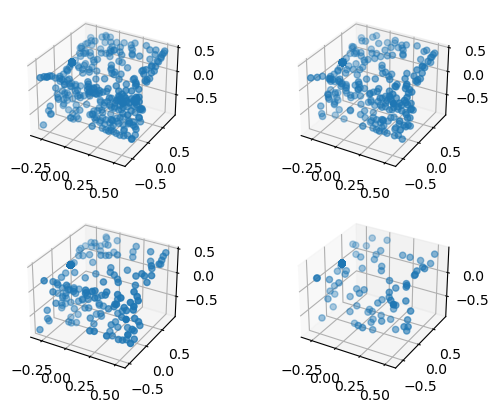

In [9]:

import open3d as o3d
import torch



print(item.shape, item)
p1 = torch.randperm(item.size(0))
p2 = torch.randperm(item.size(0))
p3 = torch.randperm(item.size(0))
p4 = torch.randperm(item.size(0))
idx1 = p1[:int(0.8*item.size(0))]
idx2 = p2[:int(0.6*item.size(0))]
idx3 = p3[:int(0.4*item.size(0))]
idx4 = p4[:int(0.2*item.size(0))]
s1 = item[idx1,:]
s2 = item[idx2,:]
s3 = item[idx3,:]
s4 = item[idx4,:]
fig = plt.figure()
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(s1[:,0], s1[:,1], s1[:,2])
ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(s2[:,0], s2[:,1], s2[:,2])
ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(s3[:,0], s3[:,1], s3[:,2])
ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(s4[:,0], s4[:,1], s4[:,2])
plt.show()



#pcd = o3d.geometry.PointCloud()
#pcd.points = o3d.utility.Vector3dVector(item)
#o3d.visualization.draw_geometries([pcd])


In [ ]:
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False) #works for me with False, on some systems needs to be true
vis.add_geometry(pcd)
vis.update_geometry(pcd)
vis.poll_events()
vis.update_renderer()
vis.capture_screen_image("./test.png")
vis.destroy_window()

: 